# Netflix Age Rating Classification

We predict the **age rating** (`age_certification`, e.g. TV-MA, PG-13) of a Netflix title
from its **description** using:

- TF–IDF text features
- A Multilayer Perceptron (MLP) classifier

Steps:
1. Load dataset  
2. Select `description` + `age_certification`  
3. Keep the most common ratings  
4. Train/test split  
5. TF–IDF + MLP pipeline  
6. Train and evaluate (accuracy + confusion matrix)


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

%matplotlib inline

DATA_PATH = "Netflix TV Shows and Movies.csv"
RANDOM_STATE = 42


## 1. Load and preview the dataset


In [9]:
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()


Shape: (5283, 11)


,index,id,title,type,description,release_year,age_certification,runtime,imdb_id,imdb_score,imdb_votes
0,0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,113,tt0075314,8.3,795222.0
1,1,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,tt0071853,8.2,530877.0
2,2,tm70993,Life of Brian,MOVIE,"Brian Cohen is an average young Jewish man, bu...",1979,R,94,tt0079470,8.0,392419.0
3,3,tm190788,The Exorcist,MOVIE,12-year-old Regan MacNeil begins to adapt an e...,1973,R,133,tt0070047,8.1,391942.0
4,4,ts22164,Monty Python's Flying Circus,SHOW,A British sketch comedy series with the shows ...,1969,TV-14,30,tt0063929,8.8,72895.0


## 2. Select description and age rating

We use:
- `description` as input text
- `age_certification` as the label

We drop missing values and keep only the **most frequent ratings** to make
the task cleaner.


In [10]:
# Keep only the columns we need and drop missing values
df_age = df[["description", "age_certification"]].dropna()
df_age["description"] = df_age["description"].astype(str)

print("Shape after selecting columns & dropping NA:", df_age.shape)
print("\nAge certification counts:")
print(df_age["age_certification"].value_counts())

# Keep only top N most common ratings
TOP_N = 6
top_ratings = df_age["age_certification"].value_counts().head(TOP_N).index
df_top = df_age[df_age["age_certification"].isin(top_ratings)].copy()

print("\nShape after filtering to top ratings:", df_top.shape)
df_top["age_certification"].value_counts()


Shape after selecting columns & dropping NA: (2996, 2)

Age certification counts:
age_certification
TV-MA    792
R        548
TV-14    436
PG-13    424
PG       237
TV-PG    172
G        105
TV-Y7    104
TV-Y      93
TV-G      72
NC-17     13
Name: count, dtype: int64

Shape after filtering to top ratings: (2609, 2)


,count
age_certification,
TV-MA,792
R,548
TV-14,436
PG-13,424
PG,237
TV-PG,172


## 3. Age rating distribution (top classes)


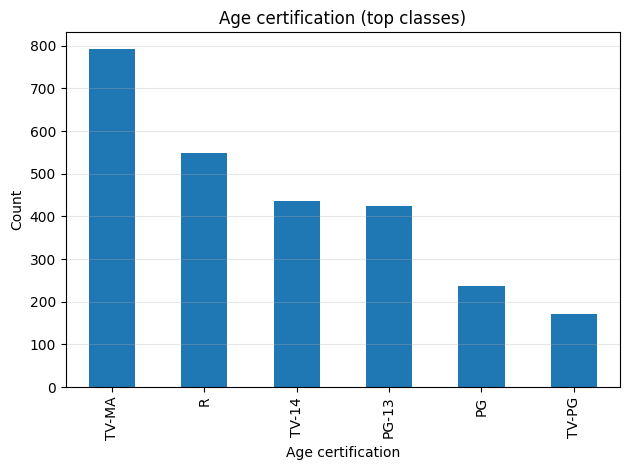

In [11]:
df_top["age_certification"].value_counts().plot(kind="bar")
plt.title("Age certification (top classes)")
plt.xlabel("Age certification")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


## 4. Train–test split


In [12]:
X = df_top["description"]
y = df_top["age_certification"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))


Train size: 2087
Test size: 522


## 5. Build and train TF–IDF + MLP model


In [13]:
mlp_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        stop_words="english",
        max_features=10000
    )),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(128,),
        activation="relu",
        solver="adam",
        max_iter=20,
        random_state=RANDOM_STATE
    ))
])

print("Training model...")
mlp_pipe.fit(X_train, y_train)
print("Done.")


Training model...
Done.


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


## 6. Evaluate the model

We check:

- Test accuracy  
- Classification report  
- Confusion matrix


Test accuracy: 0.3678

Classification report:
              precision    recall  f1-score   support

          PG       0.33      0.15      0.21        47
       PG-13       0.33      0.32      0.32        85
           R       0.36      0.37      0.36       110
       TV-14       0.27      0.21      0.24        87
       TV-MA       0.41      0.60      0.49       159
       TV-PG       0.60      0.09      0.15        34

    accuracy                           0.37       522
   macro avg       0.38      0.29      0.30       522
weighted avg       0.37      0.37      0.35       522


Confusion matrix:
 [[ 7 11 11  7 10  1]
 [ 3 27 24  6 25  0]
 [ 3 16 41  6 44  0]
 [ 1 12  8 18 47  1]
 [ 4 10 25 24 96  0]
 [ 3  6  6  5 11  3]]


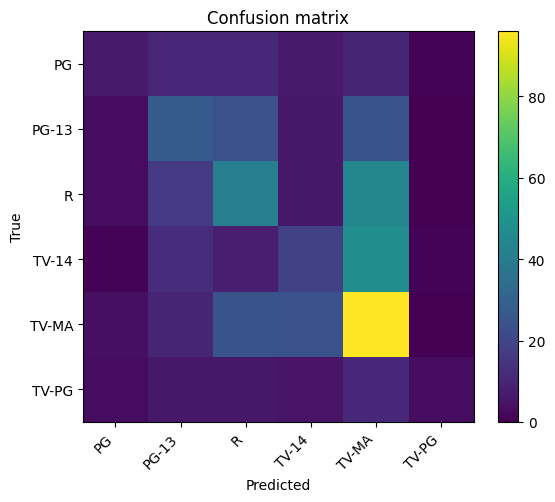

In [14]:
y_pred = mlp_pipe.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc:.4f}\n")

# Classification report
print("Classification report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
ratings = sorted(y.unique())
cm = confusion_matrix(y_test, y_pred, labels=ratings)
print("\nConfusion matrix:\n", cm)

plt.figure(figsize=(6, 5))
plt.imshow(cm)
plt.xticks(range(len(ratings)), ratings, rotation=45, ha="right")
plt.yticks(range(len(ratings)), ratings)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix")
plt.colorbar()
plt.tight_layout()
plt.show()
